In [ ]:
import numpy as np
import scipy.ndimage as nd

input = np.array([
    [1, 2, 3, 4, 5],
    [5, 4, 3, 2, 1],
    [3, 4, 5, 4, 3],
    [1, 1, 1, 1, 1],
    [2, 2, 2, 2, 2]
])

filter = np.array([
    [0, 1, 0],
    [-1, 0, 1],
    [0, -1, 0]
])

convolution_result = nd.convolve(input, filter, mode="constant")
correlation_result = nd.correlate(input, filter, mode="constant")

print("Convolution result: ")
print(convolution_result)
print("Correlation result: ")
print(correlation_result)


Convolution result: 
[[ 3  2  1  0  5]
 [-2  4  4  2  0]
 [-8 -5 -2  1  4]
 [-2 -2 -3 -2  0]
 [-3 -1 -1 -1  1]]
Correlation result: 
[[-3 -2 -1  0 -5]
 [ 2 -4 -4 -2  0]
 [ 8  5  2 -1 -4]
 [ 2  2  3  2  0]
 [ 3  1  1  1 -1]]


What is the difference between correlation and convolution (for real numbers)?

- The main difference between correlation and convolution is that in convolution, the filter is flipped before being applied to the input signal, while in correlation, it is not flipped.

-Can you calculate the output on paper, directly using the definition of 2-D convolution/correlation operator with zero-padding at input boundaries?

For convolution, flip the filter kernel horizontally and vertically before applying it to the input, then perform element-wise multiplication and summation.

For correlation, directly apply the filter to the input without flipping it, and again perform element-wise multiplication and summation.

In [ ]:
import torch as tc

input = tc.Tensor([
    [1, 2, 3, 4, 5],
    [5, 4, 3, 2, 1],
    [3, 4, 5, 4, 3],
    [1, 1, 1, 1, 1],
    [2, 2, 2, 2, 2]
]).type(tc.float32)

filter = tc.Tensor([
    [0, 1, 0],
    [-1, 0, 1],
    [0, -1, 0]
]).type(tc.float32)

print(f"Input size: {input.size()}")
print(f"Filter sie: {filter.size()}")
input = input.unsqueeze(0).unsqueeze(0) # PyTorch assumes dimension: BxCxYxX (to be discussed later)
filter = filter.unsqueeze(0).unsqueeze(0)  # PyTorch assumes dimension: BxCxYxX (to be discussed later)
print(f"Input size: {input.size()}")
print(f"Filter sie: {filter.size()}")

convolution_result = tc.nn.functional.conv2d(input, filter, padding=1)
print("Convolution result: ")
print(convolution_result)

Input size: torch.Size([5, 5])
Filter sie: torch.Size([3, 3])
Input size: torch.Size([1, 1, 5, 5])
Filter sie: torch.Size([1, 1, 3, 3])
Convolution result: 
tensor([[[[-3., -2., -1.,  0., -5.],
          [ 2., -4., -4., -2.,  0.],
          [ 8.,  5.,  2., -1., -4.],
          [ 2.,  2.,  3.,  2.,  0.],
          [ 3.,  1.,  1.,  1., -1.]]]])


In [ ]:
import torch as tc

def our_2d_correlation(input, filter, padding=1):
    batch_size, in_channels, in_height, in_width = input.size()
    _, _, filter_height, filter_width = filter.size()

    padded_height = in_height + 2 * padding
    padded_width = in_width + 2 * padding

    padded_input = tc.zeros(batch_size, in_channels, padded_height, padded_width)
    padded_input[:, :, padding:padded_height-padding, padding:padded_width-padding] = input

    result_height = in_height + 2 * padding - filter_height + 1
    result_width = in_width + 2 * padding - filter_width + 1

    result = tc.zeros(batch_size, in_channels, result_height, result_width)

    for i in range(result_height):
        for j in range(result_width):
            receptive_field = padded_input[:, :, i:i+filter_height, j:j+filter_width]
            result[:, :, i, j] = tc.sum(receptive_field * filter, dim=(2, 3))

    return result



input = tc.Tensor([
    [1, 2, 3, 4, 5],
    [5, 4, 3, 2, 1],
    [3, 4, 5, 4, 3],
    [1, 1, 1, 1, 1],
    [2, 2, 2, 2, 2]
]).type(tc.float32)

filter = tc.Tensor([
    [0, 1, 0],
    [-1, 0, 1],
    [0, -1, 0]
]).type(tc.float32)

print(f"Input size: {input.size()}")
print(f"Filter sie: {filter.size()}")
input = input.unsqueeze(0).unsqueeze(0) # PyTorch assumes dimension: BxCxYxX (to be discussed later)
filter = filter.unsqueeze(0).unsqueeze(0)  # PyTorch assumes dimension: BxCxYxX (to be discussed later)
print(f"Input size: {input.size()}")
print(f"Filter sie: {filter.size()}")

print("Padding: 1")
pytorch_convolution_result = tc.nn.functional.conv2d(input, filter, padding=1)
our_convolution_result = our_2d_correlation(input, filter, padding=1)
print("PyTorch Convolution result: ")
print(pytorch_convolution_result)
print("Our Convolution result: ")
print(our_convolution_result)
print(f"Difference: {tc.sum(pytorch_convolution_result - our_convolution_result)}")

print("Padding: 2")
pytorch_convolution_result = tc.nn.functional.conv2d(input, filter, padding=2)
our_convolution_result = our_2d_correlation(input, filter, padding=2)
print("PyTorch Convolution result: ")
print(pytorch_convolution_result)
print("Our Convolution result: ")
print(our_convolution_result)
print(f"Difference: {tc.sum(pytorch_convolution_result - our_convolution_result)}")

print("Padding: 3")
pytorch_convolution_result = tc.nn.functional.conv2d(input, filter, padding=2)
our_convolution_result = our_2d_correlation(input, filter, padding=2)
print("PyTorch Convolution result: ")
print(pytorch_convolution_result)
print("Our Convolution result: ")
print(our_convolution_result)
print(f"Difference: {tc.sum(pytorch_convolution_result - our_convolution_result)}")

Input size: torch.Size([5, 5])
Filter sie: torch.Size([3, 3])
Input size: torch.Size([1, 1, 5, 5])
Filter sie: torch.Size([1, 1, 3, 3])
Padding: 1
PyTorch Convolution result: 
tensor([[[[-3., -2., -1.,  0., -5.],
          [ 2., -4., -4., -2.,  0.],
          [ 8.,  5.,  2., -1., -4.],
          [ 2.,  2.,  3.,  2.,  0.],
          [ 3.,  1.,  1.,  1., -1.]]]])
Our Convolution result: 
tensor([[[[-3., -2., -1.,  0., -5.],
          [ 2., -4., -4., -2.,  0.],
          [ 8.,  5.,  2., -1., -4.],
          [ 2.,  2.,  3.,  2.,  0.],
          [ 3.,  1.,  1.,  1., -1.]]]])
Difference: 0.0
Padding: 2
PyTorch Convolution result: 
tensor([[[[ 0., -1., -2., -3., -4., -5.,  0.],
          [ 1., -3., -2., -1.,  0., -5., -5.],
          [ 5.,  2., -4., -4., -2.,  0., -1.],
          [ 3.,  8.,  5.,  2., -1., -4., -3.],
          [ 1.,  2.,  2.,  3.,  2.,  0., -1.],
          [ 2.,  3.,  1.,  1.,  1., -1., -2.],
          [ 0.,  2.,  2.,  2.,  2.,  2.,  0.]]]])
Our Convolution result: 
tensor([[[

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Image shape: (598, 282)
Image dtype: float32


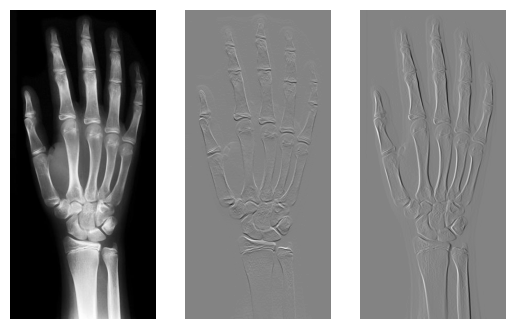

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt


image_path = '/content/drive/MyDrive/ColabNotebooks/Lab_2/xray.jpg'
image = Image.open(image_path)
array = np.array(image).astype(np.float32)
normalize = lambda image: (image - np.min(image)) / (np.max(image) - np.min(image)) # Normalization to [0-1] range
array = normalize(array)
print(f"Image shape: {array.shape}")
print(f"Image dtype: {array.dtype}")

gradient_y_np, gradient_x_np = np.gradient(array)

plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(array, cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(gradient_y_np, cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(gradient_x_np, cmap='gray')
plt.axis('off')
plt.show()

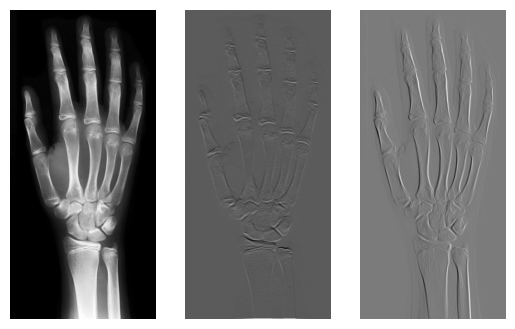

MSE Y: 0.029894152656197548
MSE X: 0.10171467810869217


In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt


gradient_y_np, gradient_x_np = np.gradient(array)

tensor = torch.from_numpy(array).unsqueeze(0).unsqueeze(0)

sobel_y = torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
sobel_x = torch.tensor([[1, 0, -1], [2, 0, -2], [1, 0, -1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)

gradient_y_tc = F.conv2d(tensor, sobel_y, padding=1)
gradient_x_tc = F.conv2d(tensor, sobel_x, padding=1)

plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(array, cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(gradient_y_tc[0, 0, :, :].numpy(), cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(gradient_x_tc[0, 0, :, :].numpy(), cmap='gray')
plt.axis('off')
plt.show()

mse = lambda a, b: np.mean((a - b) ** 2)
mse_y = mse(gradient_y_np, gradient_y_tc[0, 0, :, :].numpy())
mse_x = mse(gradient_x_np, gradient_x_tc[0, 0, :, :].numpy())
print(f"MSE Y: {mse_y}")
print(f"MSE X: {mse_x}")

- Can you describe what is the source of the difference between NumPy and PyTorch implementation? Think about that (hint: show difference images).

NumPy's np.gradient() doesn't apply padding by default, while PyTorch's F.conv2d() does zero-padding by default.

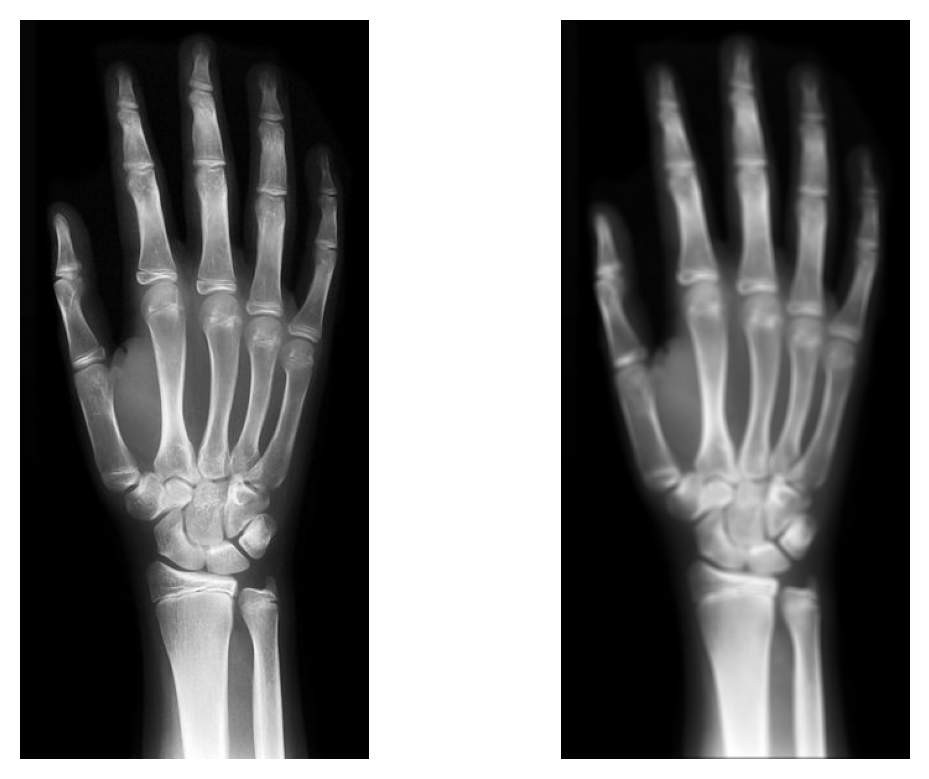

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

image_path = '/content/drive/MyDrive/ColabNotebooks/Lab_2/xray.jpg'
image = Image.open(image_path)
array = np.array(image).astype(np.float32)
normalize = lambda image: (image - np.min(image)) / (np.max(image) - np.min(image)) # Normalization to [0-1] range
array = normalize(array)

tensor = torch.from_numpy(array).unsqueeze(0).unsqueeze(0)

uniform_filter = torch.ones(1, 1, 5, 5) / 25

conv_layer = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5, padding=2, bias=False)
conv_layer.weight.data = uniform_filter

smoothed_tensor = conv_layer(tensor)

plt.figure(dpi=200)
plt.subplot(1, 2, 1)
plt.imshow(tensor[0, 0, :, :].detach().numpy(), cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(smoothed_tensor[0, 0, :, :].detach().numpy(), cmap='gray')
plt.axis('off')
plt.show()


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import time
import scipy.ndimage as nd
import matplotlib.pyplot as plt
from PIL import Image

image_path = '/content/drive/MyDrive/ColabNotebooks/Lab_2/xray.jpg'
image = Image.open(image_path)
array = np.array(image).astype(np.float32)
normalize = lambda image: (image - np.min(image)) / (np.max(image) - np.min(image)) # Normalization to [0-1] range
array = normalize(array)

tensor = torch.from_numpy(array).unsqueeze(0).unsqueeze(0)

uniform_filter = torch.ones(1, 1, 5, 5) / 25

conv_layer = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5, padding=2, bias=False)
conv_layer.weight.data = uniform_filter

start_time = time.time()
smoothed_tensor = conv_layer(tensor)
pytorch_time = time.time() - start_time

smoothed_array_pytorch = smoothed_tensor[0, 0, :, :].detach().numpy()

start_time = time.time()
smoothed_array_scipy = nd.convolve(array, uniform_filter.numpy()[0, 0], mode='constant', cval=0.0)
scipy_time = time.time() - start_time

print(f"PyTorch execution time: {pytorch_time:.6f} seconds")
print(f"SciPy execution time: {scipy_time:.6f} seconds")



PyTorch execution time: 0.028648 seconds
SciPy execution time: 0.033051 seconds


In [5]:
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import scipy.ndimage as nd

image_path = '/content/drive/MyDrive/ColabNotebooks/Lab_2/xray.jpg'
image = Image.open(image_path)
array = np.array(image).astype(np.float32)
normalize = lambda image: (image - np.min(image)) / (np.max(image) - np.min(image))
array = normalize(array)


tensor = torch.from_numpy(array).unsqueeze(0).unsqueeze(0).to('cuda')
uniform_filter = torch.ones(1, 1, 5, 5).to('cuda') / 25

conv_layer = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5, padding=2, bias=False).to('cuda')
conv_layer.weight.data = uniform_filter

start_time = time.time()
smoothed_tensor_gpu = conv_layer(tensor)
torch_time_gpu = time.time() - start_time
print(f"PyTorch GPU execution time: {torch_time_gpu} seconds")

start_time = time.time()
smoothed_array = nd.convolve(array, uniform_filter.cpu().squeeze().numpy(), mode='constant', cval=0.0)
scipy_time = time.time() - start_time
print(f"SciPy CPU execution time: {scipy_time} seconds")



PyTorch GPU execution time: 0.0003490447998046875 seconds
SciPy CPU execution time: 0.016102075576782227 seconds


In [3]:
speed_up = 5.45e-3 / 23.2e-6
print(f"Speed-up: {speed_up}")

Speed-up: 234.91379310344826


In [9]:
import torch
import torch.nn as nn
import torchsummary

class SimpleNeuralNetwork(nn.Module):
    def __init__(self):
        super(SimpleNeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(128, 128)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(64, 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.layer3(x)
        x = self.sigmoid(x)
        return x

network = SimpleNeuralNetwork()

random_input = torch.randn((4, 128))
random_output = network(random_input)

print(f"Size of the random input: {random_input.size()}")
print(f"Size of the random output: {random_output.size()}")
print("Random output: ")
print(random_output)

print("Network summary: ")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
network.to(device)
torchsummary.summary(network, (4, 128))


Size of the random input: torch.Size([4, 128])
Size of the random output: torch.Size([4, 2])
Random output: 
tensor([[0.5653, 0.5050],
        [0.5647, 0.5151],
        [0.5555, 0.5421],
        [0.5268, 0.5079]], grad_fn=<SigmoidBackward0>)
Network summary: 
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 4, 128]          16,512
              ReLU-2               [-1, 4, 128]               0
            Linear-3                [-1, 4, 64]           8,256
              ReLU-4                [-1, 4, 64]               0
            Linear-5                 [-1, 4, 2]             130
           Sigmoid-6                 [-1, 4, 2]               0
Total params: 24,898
Trainable params: 24,898
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.09
Estimated

In [3]:
import torch as tc
import torch.nn as nn
from torchsummary import summary

class SimpleConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super(SimpleConvolutionalNeuralNetwork, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=2)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=2)
        self.relu4 = nn.ReLU()
        self.avgpool = nn.AdaptiveAvgPool2d((128, 1))

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.avgpool(x)
        return x

convolutional_network = SimpleConvolutionalNeuralNetwork()

random_input = tc.randn((4, 3, 224, 224))
random_output = convolutional_network(random_input)

print(f"Size of the random input: {random_input.size()}")
print(f"Size of the random output: {random_output.size()}")
print("Random output: ")
print(random_output)

print("Network summary: ")
summary(convolutional_network.to(device), (3, 224, 224))


Size of the random input: torch.Size([4, 3, 224, 224])
Size of the random output: torch.Size([4, 128, 128, 1])
Random output: 
tensor([[[[3.5464e-03],
          [3.5464e-03],
          [5.5253e-03],
          ...,
          [8.1320e-03],
          [1.2239e-03],
          [1.2239e-03]],

         [[2.0531e-02],
          [2.0531e-02],
          [3.9072e-02],
          ...,
          [4.8365e-02],
          [3.5283e-02],
          [3.5283e-02]],

         [[1.4218e-02],
          [1.4218e-02],
          [1.0533e-02],
          ...,
          [1.3077e-02],
          [2.2682e-02],
          [2.2682e-02]],

         ...,

         [[1.4416e-02],
          [1.4416e-02],
          [1.0975e-02],
          ...,
          [2.4107e-03],
          [3.8400e-04],
          [3.8400e-04]],

         [[5.0455e-05],
          [5.0455e-05],
          [2.3182e-03],
          ...,
          [7.6191e-03],
          [1.1840e-02],
          [1.1840e-02]],

         [[0.0000e+00],
          [0.0000e+00],
     

In [13]:
import torch
import torch.nn as nn
import torchsummary

class SimpleConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super(SimpleConvolutionalNeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=2)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=2)
        self.relu4 = nn.ReLU()
        self.avgpool = nn.AdaptiveAvgPool2d((128, 1))

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.avgpool(x)
        return x

class ClassificationNeuralNetwork(nn.Module):
    def __init__(self):
        super(ClassificationNeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(128, 128)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(64, 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.layer3(x)
        x = self.sigmoid(x)
        return x

class CombinedNetwork(nn.Module):
    def __init__(self):
        super(CombinedNetwork, self).__init__()
        self.conv_network = SimpleConvolutionalNeuralNetwork()
        self.classification_network = ClassificationNeuralNetwork()

    def forward(self, x):
        x = self.conv_network(x)
        x = torch.squeeze(x)
        x = self.classification_network(x)
        return x

combined_network = CombinedNetwork()

random_input = torch.randn((4, 3, 224, 224))
random_output = combined_network(random_input)

print(f"Size of the random input: {random_input.size()}")
print(f"Size of the random output: {random_output.size()}")
print("Random output: ")
print(random_output)

print("Network summary: ")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
combined_network.to(device)
torchsummary.summary(combined_network, (3, 224, 224))


Size of the random input: torch.Size([4, 3, 224, 224])
Size of the random output: torch.Size([4, 128, 2])
Random output: 
tensor([[[0.4709, 0.4999],
         [0.4709, 0.4997],
         [0.4707, 0.5006],
         ...,
         [0.4690, 0.5035],
         [0.4710, 0.5002],
         [0.4709, 0.5002]],

        [[0.4709, 0.5000],
         [0.4709, 0.4997],
         [0.4708, 0.5005],
         ...,
         [0.4691, 0.5034],
         [0.4709, 0.5003],
         [0.4709, 0.5001]],

        [[0.4708, 0.5000],
         [0.4709, 0.4997],
         [0.4708, 0.5005],
         ...,
         [0.4691, 0.5035],
         [0.4709, 0.5004],
         [0.4709, 0.5001]],

        [[0.4709, 0.5000],
         [0.4709, 0.4997],
         [0.4707, 0.5006],
         ...,
         [0.4692, 0.5034],
         [0.4709, 0.5004],
         [0.4709, 0.5001]]], grad_fn=<SigmoidBackward0>)
Network summary: 
----------------------------------------------------------------
        Layer (type)               Output Shape        